## Covid-19 prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

Firstly, we will download our dataset from official site of Czech republic about Covid-19 development in Czech republic.

In [2]:
covid = pd.read_csv("nakaza.csv")
covid_cumulative = covid.drop(['prirustkovy_pocet_nakazenych'],axis=1)
covid_spread = covid.drop(['kumulativni_pocet_nakazenych'],axis=1)

In [3]:
ICD = pd.read_csv("nakazeni-vyleceni-umrti-testy.csv")
covid_currently = pd.DataFrame(ICD["datum"])
covid_currently["currently_infected"] = (ICD["kumulativni_pocet_nakazenych"] - ICD["kumulativni_pocet_vylecenych"])

We will predict three aspects of development covid-19 in czech republic: 
Cumulative development in `covid_cumulative`: by this data we inspect absolute number of infected people day by day.
New infected in `covid_spread`: this aspect says how many "new" people were infected.
Actual number of infected in `covid_currently`: in this `Serie` we will store information about how many infected people were there at some concrete day. This means we will take `covid_cumulative` and substract number of already dead and healed people from it.

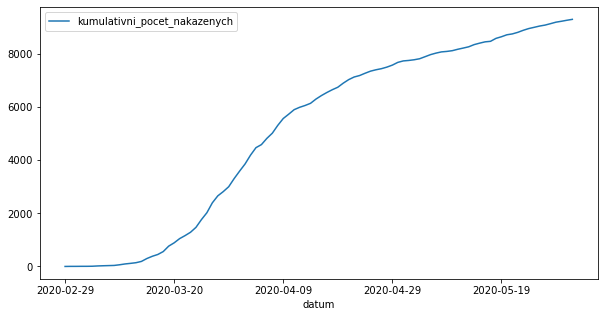

In [18]:
covid_cumulative.plot(x='datum',figsize=(10,5))

We see that around 30 days have no information at all. We can throw away these days from our dataset.

In [4]:
covid_cumulative = covid_cumulative.drop(range(33),axis=0)
covid_spread = covid_spread.drop(range(33),axis=0)
covid_currently = covid_currently.drop(range(33),axis=0)

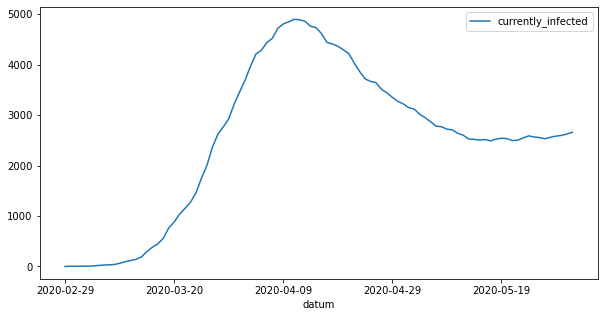

In [7]:
covid_currently.plot(x='datum',figsize=(10,5))

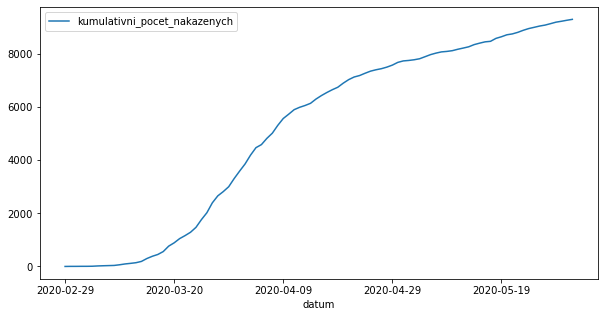

In [11]:
covid_cumulative.plot(x='datum',figsize=(10,5))

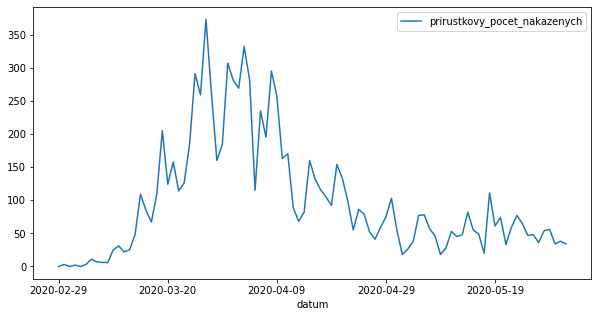

In [12]:
covid_spread.plot(x='datum',figsize=(10,5))

## Model picking

It seems that there are too few samples in our dataset. We could use LSTM in NN, which is one of the best model for time series forecasting. However LSTM needs bigger datasets to train on. It would be a little overkill to use LSTM on such small dataset and it would very probably overfit. We could try oversampling to bigger our dataset but in timeforecasting it's useless because it wouldn't give us any new information. Since the first two graphs are very smooth, the ARIMA model could be very good choice for predictions on such dataset. Let's try ARIMA and look what results will it produce.

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

def prediction(X, lag):
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(62,94):
        model = ARIMA(history, order=(lag,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    return test, predictions

In [7]:
def paint_plot(test, predictions):
    dict = {}
    for i in range(62, 94):
        dict.update({i: i-62})

    test = test.rename(index=dict)
    
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

In [5]:
dict = {}
for i in range(33, 127):
    dict.update({i: i-33})

In [6]:
covid_spread = covid_spread.rename(index=dict)
covid_cumulative = covid_cumulative.rename(index=dict)
covid_currently = covid_currently.rename(index=dict)

Let us explain why in the next step we set attribute `lag` to value 10. We used `GridSearch` from `sklearn` library to tune `lag` attribute in ARIMA. Being `lag` set to 10 provided best results. Significantly higher values for this attribute would take too long time to train, so we will leave it set at 10.

covid_spread:

predicted=73.969307, expected=55.000000
predicted=53.840930, expected=18.000000
predicted=32.179484, expected=26.000000
predicted=35.559458, expected=38.000000
predicted=40.606964, expected=77.000000
predicted=75.851110, expected=78.000000
predicted=70.516307, expected=57.000000
predicted=46.832880, expected=46.000000
predicted=36.263568, expected=18.000000
predicted=20.727396, expected=28.000000
predicted=42.046015, expected=53.000000
predicted=63.878142, expected=45.000000
predicted=53.188443, expected=48.000000
predicted=46.169009, expected=82.000000
predicted=53.737430, expected=55.000000
predicted=39.488994, expected=49.000000
predicted=49.415236, expected=20.000000
predicted=38.413359, expected=111.000000
predicted=91.735837, expected=61.000000
predicted=73.612670, expected=74.000000
predicted=73.590562, expected=33.000000
predicted=55.341901, expected=59.000000
predicted=47.455404, expected=77.000000
predicted=79.638904, expected=65.000000
predicted=65.079159, exp

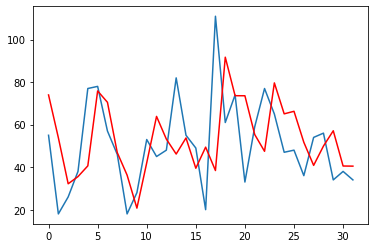

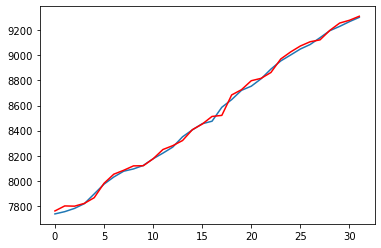

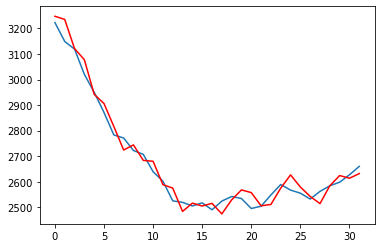

In [9]:
X1 = covid_spread.prirustkovy_pocet_nakazenych
X2 = covid_cumulative.kumulativni_pocet_nakazenych
X3 = covid_currently.currently_infected

print("covid_spread:")
print()
test1, predictions1 = prediction(X1, 10)
print("covid_cumulative:")
print()
test2, predictions2 = prediction(X2, 10)
print("covid_currently:")
print()
test3, predictions3 = prediction(X3, 10)

paint_plot(test1, predictions1)
paint_plot(test2, predictions2)
paint_plot(test3, predictions3)

## Model evaluation

As we can see upper in model training, for evaluation we used `MSE`. It might seems pretty big but when we plot our results that predictions are pretty accure. We have to have in our minds that we trained it only on about 60 samples. The lack of data displays in sudden ups and downs of function as we can see in `covid_spread` prediction. On the other hand our model can approximate smooth function really good as we can see in `covid_cumulative`. 

## Comparation of Czech republic with other countries

We will compare cumulative and new infected development of covid-19 in Czech republic to development in Italy and Austria. Let us load the data and take just the information we need.

In [10]:
covid_worldwide = pd.read_csv("owid-covid-data.csv")

In [11]:
covid_Austria = covid_worldwide.drop(range(1229),axis=0)
covid_Austria = covid_Austria.drop(range(1390,23082),axis=0)

In [12]:
covid_Italy = covid_worldwide.drop(range(10690),axis=0)
covid_Italy = covid_Italy.drop(range(10851,23082),axis=0)

In [13]:
covid_Italy_cumulative = covid_Italy.total_cases
covid_Italy_spread = covid_Italy.new_cases
covid_Austria_cumulative = covid_Austria.total_cases
covid_Austria_spread = covid_Austria.new_cases

In [14]:
dict = {}
for i in range(10757, 10851):
    dict.update({i: i-10757})
    
covid_Italy_spread = covid_Italy_spread.drop(range(10690, 10757),axis=0)
covid_Italy_cumulative = covid_Italy_cumulative.drop(range(10690, 10757),axis=0)

covid_Italy_spread = covid_Italy_spread.rename(index=dict)
covid_Italy_cumulative = covid_Italy_cumulative.rename(index=dict)

In [15]:
dict = {}
for i in range(1296, 1390):
    dict.update({i: i-1296})

covid_Austria_spread = covid_Austria_spread.drop(range(1229, 1296),axis=0)
covid_Austria_cumulative = covid_Austria_cumulative.drop(range(1229, 1296),axis=0)

covid_Austria_spread = covid_Austria_spread.rename(index=dict)
covid_Austria_cumulative = covid_Austria_cumulative.rename(index=dict)

Simillarly we tuned `lag` attribute with `GridSearch` and set the optimum for each model.

covid_Italy_cumulative:

predicted=218571.982936, expected=218268.000000
predicted=219326.003417, expected=219070.000000
predicted=219986.841921, expected=219814.000000
predicted=220681.417397, expected=221216.000000
predicted=222719.961817, expected=222104.000000
predicted=223219.041402, expected=223096.000000
predicted=224047.599329, expected=223885.000000
predicted=224622.472388, expected=224760.000000
predicted=225822.026809, expected=225435.000000
predicted=226190.863070, expected=225886.000000
predicted=226468.384301, expected=226699.000000
predicted=227517.290426, expected=227364.000000
predicted=228199.706295, expected=228006.000000
predicted=228714.259933, expected=228658.000000
predicted=229265.719154, expected=229327.000000
predicted=230090.190263, expected=229858.000000
predicted=230460.412507, expected=230158.000000
predicted=230530.387227, expected=230555.000000
predicted=231001.536437, expected=231139.000000
predicted=231821.605209, expected=231732.000000
predicted=23242

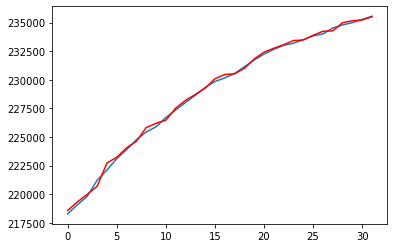

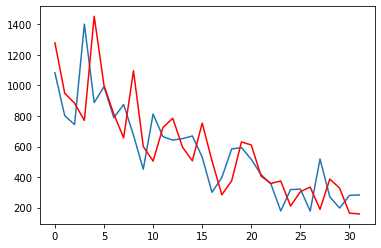

In [16]:
print("covid_Italy_cumulative:")
print()
test1, predictions1 = prediction(covid_Italy_cumulative, 5)
print("covid_Italy_spread:")
print()
test2, predictions2 = prediction(covid_Italy_spread, 5)

paint_plot(test1, predictions1)
paint_plot(test2, predictions2)

covid_Austria_cumulative:

predicted=15809.859416, expected=15777.000000
predicted=15877.472073, expected=15787.000000
predicted=15825.112102, expected=15874.000000
predicted=15980.709803, expected=15910.000000
predicted=15979.052388, expected=15964.000000
predicted=16033.429473, expected=16005.000000
predicted=16117.919003, expected=16068.000000
predicted=16119.903103, expected=16140.000000
predicted=16235.336223, expected=16154.000000
predicted=16224.136776, expected=16179.000000
predicted=16235.811751, expected=16257.000000
predicted=16344.030409, expected=16275.000000
predicted=16305.345946, expected=16332.000000
predicted=16417.404280, expected=16361.000000
predicted=16439.338515, expected=16407.000000
predicted=16440.001333, expected=16439.000000
predicted=16504.346317, expected=16459.000000
predicted=16501.875553, expected=16497.000000
predicted=16553.768434, expected=16515.000000
predicted=16563.897750, expected=16543.000000
predicted=16574.535597, expected=16594.000000
predict

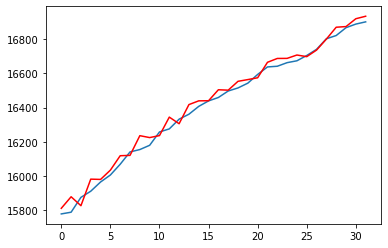

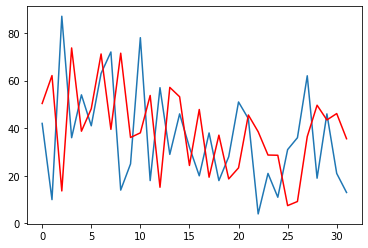

In [17]:
print("covid_Austria_cumulative:")
print()
test1, predictions1 = prediction(covid_Austria_cumulative, 10)
print("covid_Austria_spread:")
print()
test2, predictions2 = prediction(covid_Austria_spread, 5)

paint_plot(test1, predictions1)
paint_plot(test2, predictions2)

## Conclusion

As we can see ARIMA worked the best for the smooth functions. In `Italy_spread` and `Austria_spread` it didn't perform very well. The development of covid-19 in these countries were pretty wild and ARIMA can't handle it, as we mentioned upper it is mainly cause by lack of data.

One main notice: we can see that our model performs really good on absolute number of infected (cumulative data). We could use our model to predict cumulative number of infected and substract last day from it and we would get more precise prediction of newly infected.

Potentially improvments: It would be really helpful to have bigger dataset. We could use some other model to produce some noise to add into our data. Another possible way would be to predict every for example 3 hours of newly infected by dividing numbers of daily numbers. If we somehow biggered our dataset we could use `LSTM` to get more precise predictions.

I hope that you like my work on this task and thank you for this opportunity. 

Marek Jankola